Используя данные датасета, размещенного по адресу https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset, реализовать задачу прогнозирования сахарного диабета на основе вводимых данных.

Необходимо подготовить данные используя функции библиотеки pandas - dropna() или fillna(),перевести все тестовые данные в единый регистр для однообразия данных и числовой формат, убрать выбросы, используя межквартильный размах или Z-оценку, убрать дубликаты. Поделить на тестовую и обучающие выборки.

Проведите масштабирование данных.

Выбрать один из методов - логистическая регрессия или дерево решений.

Оценить качество полученной модели:

accuracy_score - оценка точности классификации. Рассчитывается для того, чтобы ограничить количество ложных срабатываний;

f1_score - среднее значение Точности измерений (Accuracy) и Отзыва (Recall) с Весами (Weight) при наличии.

Оформить выводы.

В процессе работы свои выводы обосновываете графиками.

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [23]:
data = pd.read_csv("diabetes_prediction_dataset.csv")
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [24]:
# Приведем текстовые данные к нижнему регистру
data['gender'] = data['gender'].str.lower()
data['smoking_history'] = data['smoking_history'].str.lower()

In [25]:
# Уберем выбросы с помощью межквартильного размаха
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

columns_to_remove_outliers = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for column in columns_to_remove_outliers:
    data = remove_outliers(data, column)

In [26]:
# Уберем дубликаты
data = data.drop_duplicates()

In [27]:
# Разделим данные на признаки и целевую переменную
X = data.drop('diabetes', axis=1)
y = data['diabetes']

In [28]:
# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Создадим трансформеры для числовых и категориальных признаков
numeric_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

In [30]:
# Соберем трансформеры вместе
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [31]:
# Создадим пайплайн для обучения модели
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

In [32]:
# Обучим модель
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'bmi', 'HbA1c_level'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'smoking_history'], dtype='object'))])),
                ('classifier', LogisticRegression())])

In [33]:
# Предсказания
y_pred = model.predict(X_test)

In [34]:
# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [35]:
# Вывод результатов
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.9592119706511064
F1 Score: 0.38715277777777773


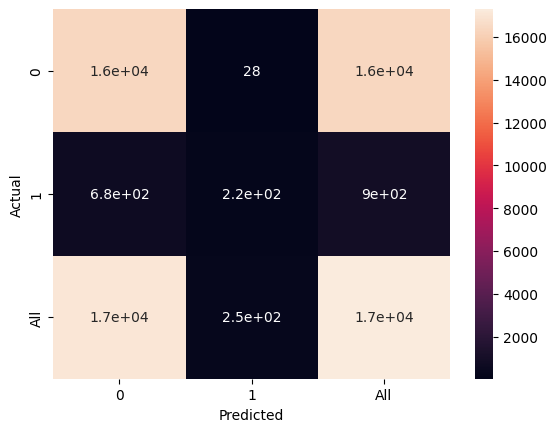

In [36]:
# Визуализация
sns.heatmap(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True), annot=True)
plt.show()

Модель достигла высокой точности (Accuracy: 95.92%), что может свидетельствовать о хорошей способности модели правильно классифицировать образцы.
Однако, стоит обратить внимание на F1 Score, который учитывает баланс между точностью и полнотой. F1 Score в данном случае равен 0.39, что может указывать на проблемы с балансом классов или наличие дисбаланса в данных.

In [37]:
# Пример вводимых значений для предсказания
new_data = pd.DataFrame({
    'gender': ['female'],
    'age': [45.0],
    'hypertension': [0],
    'heart_disease': [0],
    'smoking_history': ['never'],
    'bmi': [22.5],
    'HbA1c_level': [5.8],
    'blood_glucose_level': [120]
})

In [38]:
# Приведем текстовые данные к нижнему регистру
new_data['gender'] = new_data['gender'].str.lower()
new_data['smoking_history'] = new_data['smoking_history'].str.lower()

In [39]:
# Масштабирование числовых данных
numeric_columns = X.select_dtypes(include=['float64']).columns
new_data[numeric_columns] = model.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].transform(new_data[numeric_columns])

In [40]:
# Предсказание с использованием обученной модели
prediction = model.predict(new_data)

In [41]:
# Вывод результата предсказания
print(f"Предсказание модели: {prediction}")

Предсказание модели: [0]


Это означает, что модель предсказывает класс 0 (отсутствие диабета) для предоставленных входных данных.

In [43]:
# Получим вероятности для ROC-кривой
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

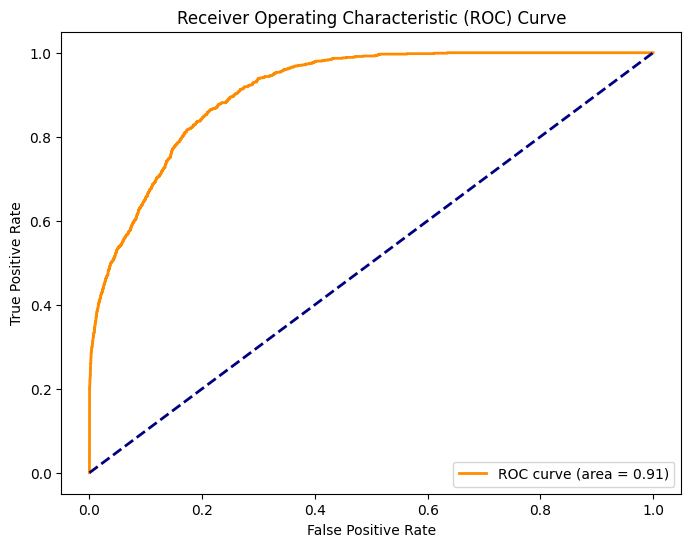

In [44]:
# Визуализация ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

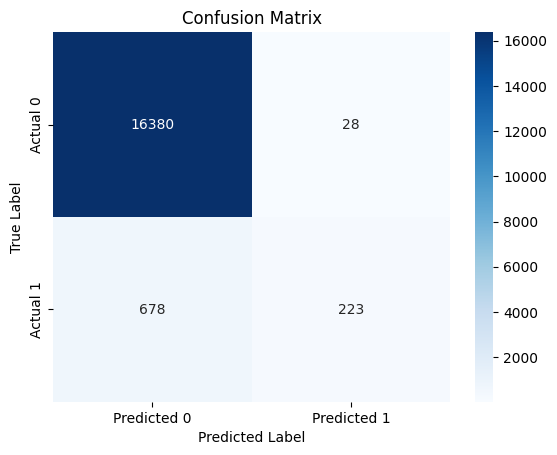

In [45]:
# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Создали ROC-кривую для визуализации характеристик работы модели и тепловую карту для матрицы ошибок, которая покажет, какие прогнозы были верны, а какие нет.